In [1]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mohamedmustafa/real-life-violence-situations-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dungvu29
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mohamedmustafa/real-life-violence-situations-dataset


100%|██████████| 3.58G/3.58G [00:39<00:00, 96.9MB/s]


In [2]:
import cv2
import os
import glob
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import numpy as np
SOURCE_DIR = '/content/real-life-violence-situations-dataset/Real Life Violence Dataset'
TARGET_DIR = '/content/data_frames'
IMG_SIZE = 128
NUM_FRAMES = 16 # 16 frame

def extract_frames(video_path):
    try:
        # Lấy nhãn lớp (Violence / NonViolence)
        class_name = os.path.basename(os.path.dirname(video_path))
        file_name = os.path.splitext(os.path.basename(video_path))[0]

        # Tạo thư mục đích: data_frames/Violence/V_123
        output_dir = os.path.join(TARGET_DIR, class_name, file_name)
        if os.path.exists(output_dir): return
        os.makedirs(output_dir, exist_ok=True)

        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total_frames <= 0: return

        # Lấy mẫu đều
        indices = np.linspace(0, total_frames-1, NUM_FRAMES).astype(int)

        frame_idx = 0
        saved_count = 0
        while True:
            ret, frame = cap.read()
            if not ret: break
            if frame_idx in indices:
                frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
                cv2.imwrite(os.path.join(output_dir, f"frame_{saved_count:02d}.jpg"), frame)
                saved_count += 1
            frame_idx += 1
        cap.release()
    except: pass

# Tìm video
video_files = glob.glob(os.path.join(SOURCE_DIR, '*/*.mp4'))
print(f" Tìm thấy {len(video_files)} video. Bắt đầu tách ảnh...")

with ThreadPoolExecutor(max_workers=8) as executor:
    list(tqdm(executor.map(extract_frames, video_files), total=len(video_files)))

print(" Tách ảnh xong")

 Tìm thấy 1951 video. Bắt đầu tách ảnh...


100%|██████████| 1951/1951 [07:29<00:00,  4.34it/s]

 Tách ảnh xong


In [3]:
%%writefile dataset.py
import os
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import glob
from sklearn.model_selection import train_test_split

class ViolenceDataset(Dataset):
    def __init__(self, data_list, transform=None, clip_len=16):
        self.data_list = data_list
        self.transform = transform
        self.clip_len = clip_len

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        folder_path, label = self.data_list[idx]
        frames = []

        # Lấy danh sách ảnh
        images = sorted(glob.glob(os.path.join(folder_path, "*.jpg")))

        # Sampling (Nếu thiếu thì bù, thừa thì lấy đủ)
        if len(images) < self.clip_len:
            # Padding
            current_frames = [self.load_img(p) for p in images]
            while len(current_frames) < self.clip_len:
                current_frames.append(current_frames[-1].clone() if current_frames else torch.zeros(3, 128, 128))
            frames = current_frames
        else:
            # Lấy đều
            indices = np.linspace(0, len(images)-1, self.clip_len).astype(int)
            frames = [self.load_img(images[i]) for i in indices]

        return torch.stack(frames), label

    def load_img(self, path):
        with Image.open(path) as img:
            return self.transform(img)

def get_loaders(data_dir, batch_size=16, clip_len=16, img_size=128):
    # 1. Quét toàn bộ dữ liệu
    all_data = []
    classes = ['NonViolence', 'Violence'] # 0: Non, 1: Violence

    for class_idx, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir): continue
        for folder_name in os.listdir(class_dir):
            folder_path = os.path.join(class_dir, folder_name)
            if os.path.isdir(folder_path):
                all_data.append((folder_path, class_idx))

    # 2. Chia Train/Test (90% - 10%)
    train_list, val_list = train_test_split(all_data, test_size=0.1, random_state=42, shuffle=True)

    # 3. Augmentation
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=10),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #normallize chuẩn imaget
    ])

    val_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_ds = ViolenceDataset(train_list, transform=train_transform, clip_len=clip_len)
    val_ds = ViolenceDataset(val_list, transform=val_transform, clip_len=clip_len)

    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader

Writing dataset.py


In [4]:
%%writefile model.py
import torch
import torch.nn as nn
import torchvision.models as models

class AttentionBlock(nn.Module):
    def __init__(self, feature_dim):
        super(AttentionBlock, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // 2),
            nn.Tanh(),
            nn.Linear(feature_dim // 2, 1),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        # x: [Batch, Seq, Features]
        weights = self.attention(x)
        context = torch.sum(x * weights, dim=1)
        return context

class ViolenceModel(nn.Module):
    def __init__(self, hidden_size=128, num_layers=1, dropout=0.5):
        super(ViolenceModel, self).__init__()

        # 1. Backbone: MobileNetV2
        mobilenet = models.mobilenet_v2(weights='DEFAULT')
        self.features = nn.Sequential(*list(mobilenet.features.children()))
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # KHÓA CHẶT BACKBONE để giamr loss
        for p in self.features.parameters():
            p.requires_grad = False

        # 2. Adapter (Cầu nối )
        self.adapter = nn.Sequential(
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(1280, 512), # Giảm chiều xuống 512 cho nhẹ
            nn.ReLU()
        )

        # 3. Bi-LSTM (dùng lstm 2 chiều)
        self.lstm = nn.LSTM(
            input_size=512, # Đã giảm chiều từ adapter
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        # 4. Attention (Giúp model biết frame nào là đánh nhau)
        self.attention = AttentionBlock(hidden_size * 2)

        # 5. Classifier Head
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 2, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        b, s, c, h, w = x.size()

        # CNN Phase
        x = x.view(b * s, c, h, w)
        with torch.no_grad(): # Freeze tuyệt đối
            x = self.features(x)
            x = self.pool(x)

        # Adapter
        x = self.adapter(x)
        x = x.view(b, s, -1)

        # RNN Phase
        lstm_out, _ = self.lstm(x)

        # Attention Pooling (Tốt hơn Mean/Max)
        context = self.attention(lstm_out)

        # Head
        logits = self.head(context)
        return logits

Writing model.py


In [10]:
%%writefile train.py
import torch
import torch.nn as nn
from dataset import get_loaders
from model import ViolenceModel
from tqdm import tqdm
import wandb
import os
from sklearn.metrics import f1_score, accuracy_score

# --- CẤU HÌNH ---
DATA_DIR = '/content/data_frames' # Folder ảnh đã tách
BATCH_SIZE = 16
EPOCHS = 50
LR = 0.01                 # SGD cần LR khởi điểm lớn
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def main():
    wandb.init(project="violence-detection-new", config={"model": "MobileNetV2-BiLSTM", "opt": "SGD"})

    # 1. Data Loaders
    print("Đang load dữ liệu...")
    if not os.path.exists(DATA_DIR):
        print(f" LỖI: Không tìm thấy thư mục {DATA_DIR}")
        return

    # Sử dụng hàm get_loaders từ dataset.py
    train_loader, val_loader = get_loaders(DATA_DIR, batch_size=BATCH_SIZE, clip_len=16, img_size=128)

    print(f" Train batches: {len(train_loader)} | Val batches: {len(val_loader)}")

    # 2. Model (ViolenceModel)
    model = ViolenceModel(hidden_size=128, num_layers=1).to(DEVICE)

    # 3. Optimizer: SGD + Momentum
    optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)

    # Loss với Label Smoothing
    criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # 4. Scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    best_val_loss = float('inf')

    for epoch in range(EPOCHS):
        # --- TRAIN ---
        model.train()
        train_loss = 0.0
        loop = tqdm(train_loader, desc=f"Ep {epoch+1}/{EPOCHS}")

        for vid, label in loop:
            vid, label = vid.to(DEVICE), label.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(vid)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)

        # --- VALIDATE ---
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for vid, label in val_loader:
                vid, label = vid.to(DEVICE), label.to(DEVICE)
                outputs = model(vid)
                loss = criterion(outputs, label)
                val_loss += loss.item()

                preds = outputs.argmax(1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(label.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(all_labels, all_preds) * 100
        f1 = f1_score(all_labels, all_preds, average='binary')

        # Lấy Learning Rate hiện tại để in ra
        current_lr = optimizer.param_groups[0]['lr']

        print(f" Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Acc: {val_acc:.2f}% | F1: {f1:.4f} | LR: {current_lr:.2e}")

        wandb.log({
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "val_acc": val_acc,
            "f1": f1,
            "lr": current_lr,
            "epoch": epoch+1
        })

        scheduler.step(avg_val_loss)

        # Lưu model theo Loss thấp nhất
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f" Saved Best Model! (Loss: {avg_val_loss:.4f})")

    wandb.finish()

if __name__ == '__main__':
    main()

Overwriting train.py


In [11]:
!python train.py

wandb: Currently logged in as: dung-vx223766 (dung-vx223766-abc7) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: ⢿ Waiting for wandb.init()...
wandb: ⣻ setting up run rcg1dqsh (0.2s)
wandb: ⣽ setting up run rcg1dqsh (0.2s)
wandb: ⣾ setting up run rcg1dqsh (0.2s)
wandb: Tracking run with wandb version 0.23.1
wandb: Run data is saved locally in /content/wandb/run-20251219_063353-rcg1dqsh
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run expert-sun-9
wandb: ⭐️ View project at https://wandb.ai/dung-vx223766-abc7/violence-detection-new
wandb: 🚀 View run at https://wandb.ai/dung-vx223766-abc7/violence-detection-new/runs/rcg1dqsh
Đang load dữ liệu...
 Train batches: 110 | Val batches: 13
Ep 1/50: 100% 110/110 [00:47<00:00,  2.30it/s, loss=0.702]
 Train Loss: 0.4845 | Val Loss: 0.4474 | Acc: 84.18% | F1: 0.8324 | LR: 1.00e-02
 Saved Best Model! (Loss: 0.4474)
Ep 2/50: 100% 110/110 [00:44<00:00,  2.46it/s, loss=0.258]
 Train Loss: 0.3908 | Val Loss

In [12]:
!pip install plt


 tính toán ROC...


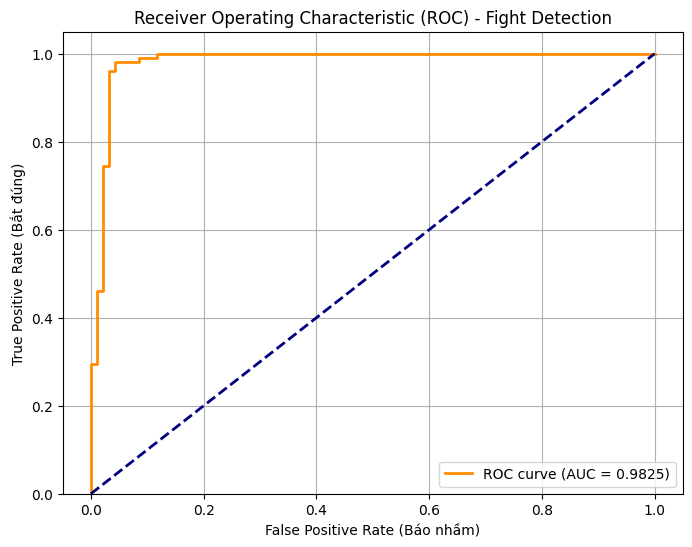

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch
from model import ViolenceModel
from dataset import ViolenceDataset
from torch.utils.data import DataLoader


DATA_DIR = '/content/data_frames'
MODEL_PATH = 'best_model.pth'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
from dataset import get_loaders
_, val_loader = get_loaders(DATA_DIR, batch_size=16, clip_len=16, img_size=128)

model = ViolenceModel(hidden_size=128, num_layers=1).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

y_true = []
y_scores = []

print(" tính toán ROC...")
with torch.no_grad():
    for vid, label in val_loader:
        vid = vid.to(DEVICE)
        outputs = model(vid)
        probs = torch.nn.functional.softmax(outputs, dim=1)

        y_true.extend(label.numpy())
        y_scores.extend(probs[:, 1].cpu().numpy())

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Báo nhầm)')
plt.ylabel('True Positive Rate (Bắt đúng)')
plt.title('Receiver Operating Characteristic (ROC) - Fight Detection')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()